In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import itertools
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys
%matplotlib inline

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [3]:
df = alldata[(alldata['Store']==1) & (alldata['Dept']==1)][['Weekly_Sales']]

In [4]:
df.head()

,Weekly_Sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


In [5]:
y = df['Weekly_Sales']

In [6]:
type(y)

pandas.core.series.Series

Text(0,0.5,'Weekly Sales')

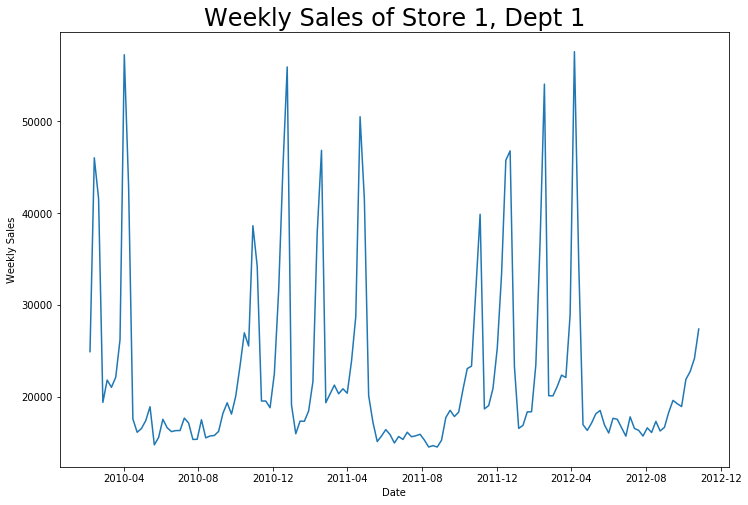

In [7]:
# Line plot to display the sales by date
plt.figure(figsize=(12,8))
plt.plot(df)
plt.title('Weekly Sales of Store 1, Dept 1', fontsize=24)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

In [8]:
# From this plot, we can see that there is seasonality (large spikes around the same months each year)

### Seasonal Decomposition graphs 

In [9]:
## Let's look at the trend, seasonality and residuals by plotting the seasonal decomposition graphs

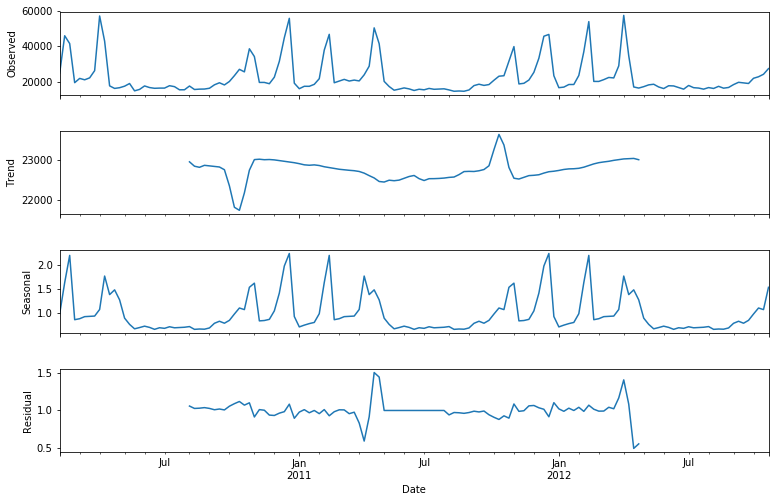

In [10]:
# multiplicative seasonal decomposition

decomp_mul = seasonal_decompose(y, model='multiplicative') #where y = df['Weekly_Sales']
fig = decomp_mul.plot()
fig.set_size_inches(12, 8)

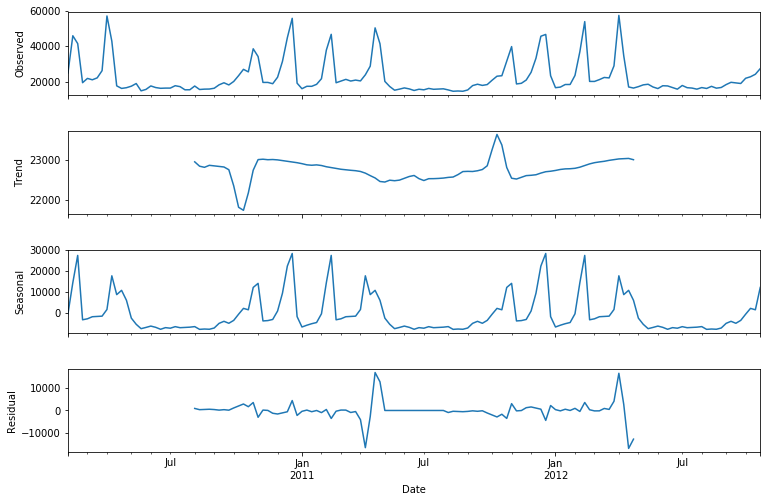

In [11]:
# additive seasonal decomposition

decomp_add = seasonal_decompose(y, model='additive')
fig = decomp_add.plot()
fig.set_size_inches(12, 8)

In [12]:
## Seasonality is seen from the Observed as well the seasonal graph (splikes appearing in intervals).
## There does not seem to be trend in the data, from the trend graph

In [13]:
## Scale is different in additive graphs for Seasonal and residuals.
## Additive decomposition shows high residual values.

In [14]:
## Before forecasting models can be applied, the series must be transformed into a stationary time series. 
## Stationarity can be tested using the Augmented Dickey Fuller test. 

### Augmented Dickey-Fuller Test for Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

In [16]:
# H0: The time series is non-stationary
# Ha: The time series is stationary

In [17]:
## If the test statistic is smaller than the critical value, the NULL hypothesis can be rejected.

In [18]:
y = df['Weekly_Sales']

In [19]:
#Perform Dickey-Fuller test:
def adf_test(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y, autolag='AIC')
    print('Test Statistic: ','%f' %(dftest[0]))
    print('p-value: ','%f' %(dftest[1]))
    print('#Lags Used: ','%d' %(dftest[2]))
    print('Number of Observations Used: ','%d' %(dftest[3]))
    print('Critical Values:')
    for key,value in dftest[4].items():            
        print('\t%s: %.3f' %(key, value))


In [20]:
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic:  -2.522164
p-value:  0.110174
#Lags Used:  6
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [21]:
## Because the test statistic is above the 5% critical value and the p-value is larger than 0.05 
## the null hypothesis of the Augmented Dickey-Fuller test cannot be rejected, and it 
## can be said that the series is not stationary.

### First Difference

In [22]:
## Take the first difference of y, and then check for statonarity using the ADF test.

In [23]:
# difference time series
y_diff = np.diff(y)

In [24]:
adf_test(y_diff)

Results of Dickey-Fuller Test:
Test Statistic:  -11.044311
p-value:  0.000000
#Lags Used:  5
Number of Observations Used:  136
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


In [25]:
## Because the test statistic is less than the critical values, we can reject the Null hypothesis and conclude that the 
## time series with first difference is stationary

### ARIMA

In [26]:
## We can use the ARIMA (autoregressive integrated moving average) model to fit the time series data 
## in order to predict future points in the series.

In [27]:
## There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.
## These three parameters account for seasonality, trend, and noise in datasets

## p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
## d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing.
## q is the moving average part of the model. This allows us to set the error of our model as a 
## linear combination of the error values observed at previous time points in the past.

In [28]:
## Since we have time series with seasonal effects, we can use the seasonal ARIMA,
## which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters, 
## while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 
## The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

In [29]:
y = df['Weekly_Sales']

In [30]:
y.tail()

Date
2012-09-28    18947.81
2012-10-05    21904.47
2012-10-12    22764.01
2012-10-19    24185.27
2012-10-26    27390.81
Name: Weekly_Sales, dtype: float64

In [31]:
# Split train and test sets
y_train = y[:'2011']
y_test = y['2012':]

In [32]:
y_train['2011'] ## data set for in-sample predictions
#y_train.tail()

Date
2011-01-07    15984.24
2011-01-14    17359.70
2011-01-21    17341.47
2011-01-28    18461.18
2011-02-04    21665.76
2011-02-11    37887.17
2011-02-18    46845.87
2011-02-25    19363.83
2011-03-04    20327.61
2011-03-11    21280.40
2011-03-18    20334.23
2011-03-25    20881.10
2011-04-01    20398.09
2011-04-08    23873.79
2011-04-15    28762.37
2011-04-22    50510.31
2011-04-29    41512.39
2011-05-06    20138.19
2011-05-13    17235.15
2011-05-20    15136.78
2011-05-27    15741.60
2011-06-03    16434.15
2011-06-10    15883.52
2011-06-17    14978.09
2011-06-24    15682.81
2011-07-01    15363.50
2011-07-08    16148.87
2011-07-15    15654.85
2011-07-22    15766.60
2011-07-29    15922.41
2011-08-05    15295.55
2011-08-12    14539.79
2011-08-19    14689.24
2011-08-26    14537.37
2011-09-02    15277.27
2011-09-09    17746.68
2011-09-16    18535.48
2011-09-23    17859.30
2011-09-30    18337.68
2011-10-07    20797.58
2011-10-14    23077.55
2011-10-21    23351.80
2011-10-28    31579.90
2011-1

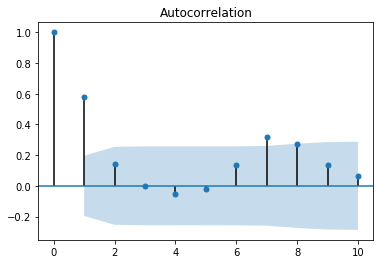

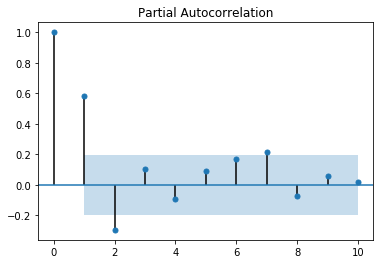

In [33]:
## Plot the ACF and PACF graphs to get an idea of what the p,q parameters should be:

smt.graphics.plot_acf(y_train, lags=10)
smt.graphics.plot_pacf(y_train, lags=10);

In [34]:
## From PACF: since the first significant spike in the blue shaded area is at 2 (negative correlation),
## we can say that the p = 2
## From ACF: since the first significant spike iin the blue shaded area is ar 2, we can say that q = 2
## And since ADF test showed that the times series became stationary when taking the 1st difference, d = 1.

## However, we use the range(0,2) to come up with the optimal parameters for p and q using grid search

In [35]:
#### Grid Search to find the optimal parameters p,d,q,P,D,Q where s = 52 (weeks)

In [36]:
# Define the p, d and q parameters to take any value between 0 and 2, and 52 weeks for periodicity 's'
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [37]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [38]:
seasonal_pdq

[(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 1, 0, 52),
 (0, 1, 1, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52),
 (1, 1, 0, 52),
 (1, 1, 1, 52)]

In [39]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
           # print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}52 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Best SARIMAX(1, 1, 1)x(0, 1, 0, 52)52 model - AIC:993.7306012242392


In [40]:
## Since (1, 1, 1)x(0, 1, 0, 52) is found to be the best model, we can use these parameters

In [41]:
model = sm.tsa.statespace.SARIMAX(y_train, order = (1,1,1),seasonal_order = (0, 1, 0, 52),enforce_stationarity=True,
                                                enforce_invertibility=True)

In [42]:
result = model.fit()

In [43]:
print(result.aic)

993.730601224


In [44]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 52)   Log Likelihood                -493.865
Date:                            Mon, 29 Jan 2018   AIC                            993.731
Time:                                    22:56:24   BIC                           1001.546
Sample:                                02-05-2010   HQIC                           996.894
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6455      0.128      5.060      0.000       0.395       0.896
ma.L1         -0.9028      0.062   

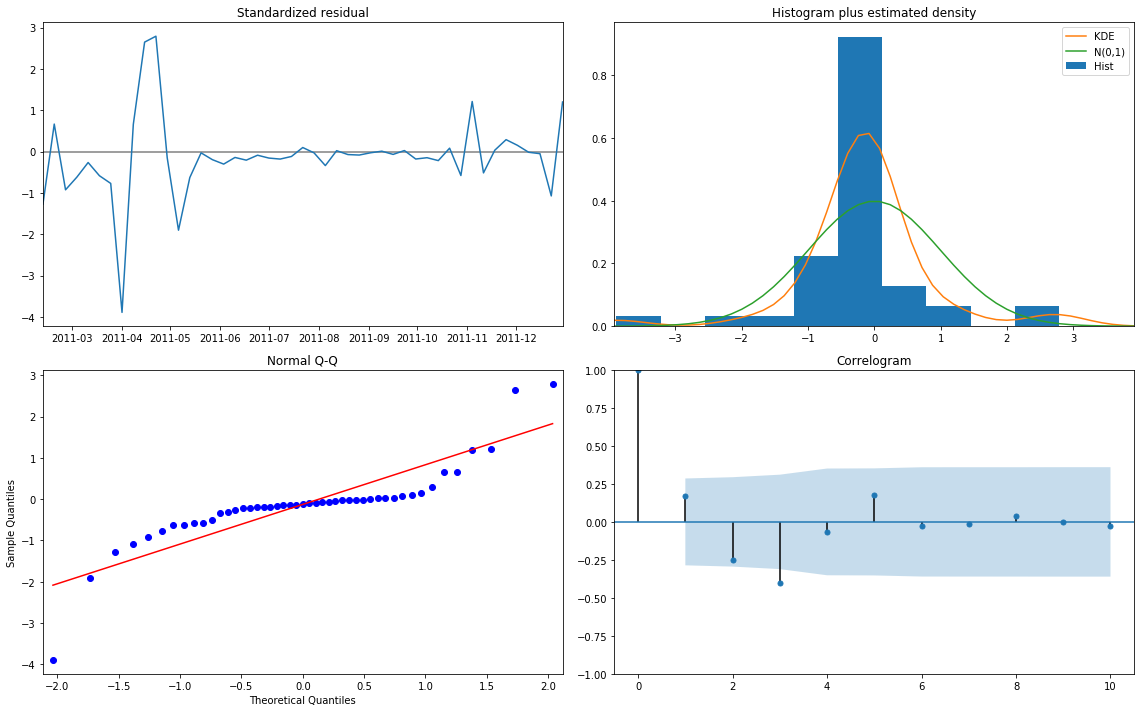

In [45]:
result.plot_diagnostics(figsize=(16,10))
plt.tight_layout()

In [46]:
## The residuals does not display any seasonality or trend behavior. It appears to be white noise
## In the histogram, the green line is the standard normal distribution, and the kde of the time series is 
## plotted in the orange line. 
# Question: Since the orange is also bell shaped with the center 0, and although not overlapping the green line,
## can we say that the time series is normal?
## Correlogram shows that the time series residuals show low correlations with lagged residuals. Although there is 
## one big spike at 2.5

### One step ahead prediction

In [47]:
## One step ahead prediction: Use the model to forecast for time periods that we already have data for,
## so we can understand how accurate are the forecasts.

In [48]:
## Predict for time period already avaiable in train data (for year 2011)
forecast = result.predict(start = y_train['2011'].index[0],end=y_train['2011'].index[-1],dynamic= True) 

In [49]:
## Calculate the CI for predicted data
forecast_ci = result.get_prediction(start = y_train['2011'].index[0],end=y_train['2011'].index[-1],dynamic= True)  

In [50]:
forecast.head()

2011-01-07    21492.282616
2011-01-14    23020.693952
2011-01-21    24007.321749
2011-01-28    24644.214702
2011-02-04    49682.713979
Freq: W-FRI, dtype: float64

In [51]:
forecast.tail()

2011-12-02    48024.472676
2011-12-09    57004.562678
2011-12-16    70419.772679
2011-12-23    81438.142679
2011-12-30    44631.492680
Freq: W-FRI, dtype: float64

In [52]:
forecast_ci.conf_int().head()

,lower Weekly_Sales,upper Weekly_Sales
2011-01-07,3445.506124,39539.059107
2011-01-14,469.432311,45571.955594
2011-01-21,-912.160546,48926.804045
2011-01-28,-1756.186466,51044.615870
2011-02-04,22238.440548,77126.987410


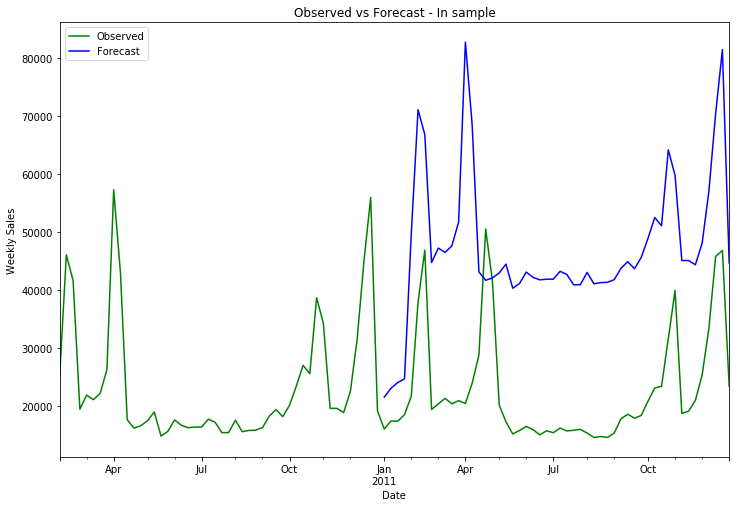

In [53]:
## Plot the y_train (observed) and the predicted (forecast)

y_train.plot(figsize=(12,8),color='green',label='Observed')
forecast.plot(figsize=(12,8),color='blue',label='Forecast')
plt.ylabel('Weekly Sales')
plt.title('Observed vs Forecast - In sample')
plt.legend(loc='best');

In [54]:
y_hat = forecast
y_true = y_train['2011']

In [55]:
y_hat.shape

(52,)

In [56]:
mse_cv = mean_squared_error(y_true, y_hat)
rmse_cv = np.sqrt(mse_cv)
print(mse_cv)
print(rmse_cv)

702460202.98
26503.9657972


In [57]:
mean_absolute_error(y_true, y_hat)

24767.506857789936

In [58]:
## Question: From the above MAE, MSE, how to suggest that the result is good or bad?
## should different range, say (0,3) be chosen to compute the p,q parameters using grid search?

### Out of sample prediction

In [59]:
## Predict for 200 weeks, such that it includes the test_df timeframe
forecast_out = result.predict(start=pd.to_datetime('2010-02-05'), 
                              end=pd.to_datetime('2012-10-26'),
                              dynamic=False, full_results=True)

In [60]:
forecast_out.head()

2010-02-05        0.000000
2010-02-12    20891.892906
2010-02-19    38771.436258
2010-02-26    36335.581475
2010-03-05    19608.455259
Freq: W-FRI, dtype: float64

In [61]:
forecast_out.tail()

2012-09-28    18968.508749
2012-10-05    21428.408699
2012-10-12    23708.378668
2012-10-19    23982.628647
2012-10-26    32210.728634
Freq: W-FRI, dtype: float64

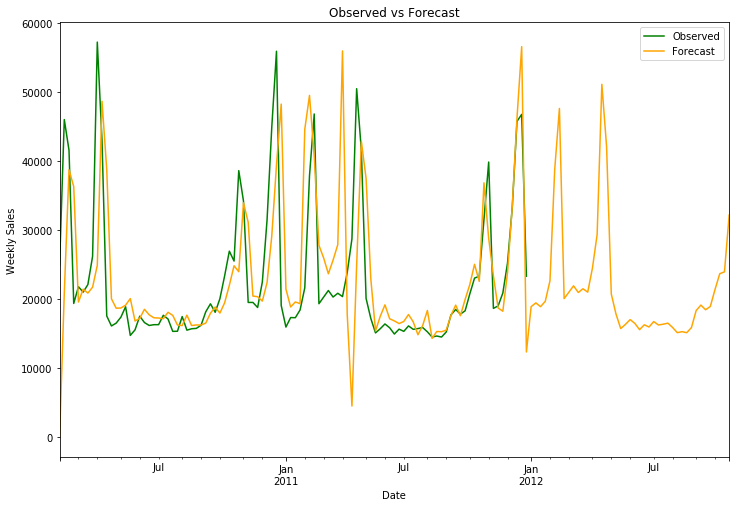

In [62]:
## Plot the y_train (observed) and the predicted (forecast)

y_train.plot(figsize=(12,8),color='green',label='Observed')
forecast_out.plot(figsize=(12,8),color='orange',label='Forecast')
plt.ylabel('Weekly Sales')
plt.title('Observed vs Forecast')
plt.legend(loc='best');

In [63]:
### Metrics
y_test.head()

Date
2012-01-06    16567.69
2012-01-13    16894.40
2012-01-20    18365.10
2012-01-27    18378.16
2012-02-03    23510.49
Name: Weekly_Sales, dtype: float64

In [64]:
start = y_test.index[0]
end = y_test.index[-1]
y_hat = forecast_out[start:end]
y_true = y_test

In [65]:
df = pd.concat((y_hat, y_true), axis=1)
df.columns = ['y_hat', 'y_true']

In [66]:
df

,y_hat,y_true
Date,,
2012-01-06,18936.035440,16567.69
2012-01-13,19488.770827,16894.40
2012-01-20,18939.451484,18365.10
2012-01-27,19716.330012,18378.16
2012-02-03,22699.603711,23510.49
2012-02-10,38778.154951,36988.49
2012-02-17,47644.636044,54060.10
2012-02-24,20103.066429,20124.22
2012-03-02,21028.418572,20113.03


In [67]:
mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
print(mse)
print(rmse)

73086618.1189
8549.07118457


In [68]:
mean_absolute_error(y_true, y_hat)

3564.3695882292382